# Extension of Locality Sensitive Hashing to Classification Models

Goal: attempt to extend the LSH outputs into a CNN model for image classification. 

* Deep Neural Networks, including CNNs (Yale Dataset)
* Deep Neural Networks, with Low-Rank (MNIST Dataset) and,
* Adaptive Dropout (MNIST Dataset)

Note: A Tensorflow-GPU kernel was used for this portion, but data are trivial enough that it should not be difficult on a CPU, albeit much slower

In [133]:
import copy
import os
import pickle
import time

import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Layer
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from skimage.io import imread
from skimage.transform import resize
from sklearn.neighbors import KNeighborsClassifier

from src.Fly import Flylsh as Fly
from src import mnist_loader
from src.Network import Network
from src.utils import benchmark, findSpecificTrainInput, TimeHistory

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. LSH DNN for Yale Dataset

### Load LSH (computed in LSH_clustering) and Yale Face data

In [2]:
# read and reshape hashes
pickle_in = open(os.path.join("results", "face_hashes_hashlen_0.05k.pkl"),"rb")
hashes = pickle.load(pickle_in)
print (hashes.shape)
temp = np.array([xx.toarray() for xx in hashes])
print (temp.shape)
hashes = np.squeeze(temp, axis=(2,))
print (hashes.shape)
# print (hashes)

faces = [os.path.join("data","yalefaces", img) for img in os.listdir(os.path.join("data","yalefaces")) if img.startswith("subject")]
labels = [int(f.split("subject")[-1][:2]) for f in faces]
data = np.array([np.flipud(imread(faces[i])) for i in range(len(faces))])
input_row_data = data    # secondary reference to maintain original data obj
input_data = np.array(data)

(166,)
(166, 81920, 1)
(166, 81920)


### Pepare labels for clustering
These are given by the subject number

In [3]:
num_kind = 15
ind = np.array([158, 145, 162, 165, 135, 110, 95, 100, 80, 60, 65, 38, 30, 15, 3])
print ([labels[i] for i in ind])

labels = np.array(labels)
label_out = np.zeros((labels.shape[0], num_kind))
for i in range(len(labels)):
    label_out[i][labels[i]-1] = 1

train_mask = np.ones(np.array(labels).shape, bool)
train_mask[ind] = False
train_labels = label_out[train_mask]

test_mask = np.invert(train_mask)
test_labels = label_out[test_mask]

print (train_labels.shape)
print (test_labels.shape)



[15, 14, 15, 15, 13, 10, 9, 10, 8, 6, 6, 4, 3, 2, 1]
(151, 15)
(15, 15)


### Prepare raw and processed data, for feeding into NN

In [4]:
# prepare row data
row_data = input_row_data.reshape((input_row_data.shape[0], input_row_data.shape[1] * input_row_data.shape[2]))
train_row_data = row_data[train_mask]
test_row_data = row_data[test_mask]

print (row_data.shape)
print (train_row_data.shape)
print (test_row_data.shape)

(166, 77760)
(151, 77760)
(15, 77760)


In [5]:
# prepare resized data
resize_64 = [resize(img, (64, 64), anti_aliasing=True) for img in data]
input_data = np.array(resize_64)
resized_data = input_data.reshape((input_data.shape[0], input_data.shape[1] * input_data.shape[2]))
train_resized_data = resized_data[train_mask]
test_resized_data = resized_data[test_mask]

print (resized_data.shape)
print (train_resized_data.shape)
print (test_resized_data.shape)

C:\Users\bcech\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(166, 4096)
(151, 4096)
(15, 4096)


In [6]:
# prepare fly data
train_hashes = hashes[train_mask]
test_hashes = hashes[test_mask]

print (hashes.shape)
print (train_hashes.shape)
print (test_hashes.shape)

(166, 81920)
(151, 81920)
(15, 81920)


## Create Keras Deep Network Model for full Images

In [7]:
# model for raw input: input_dim=(243, 320)= 77760
model = Sequential()
model.add(Dense(1280, input_dim=77760, activation='relu'))
model.add(Dense(15, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### And train it

In [8]:
model.fit(train_row_data, train_labels, epochs=15)

Epoch 1/15
151/151 [==============================] - 5s 33ms/step - loss: 15.0507 - acc: 0.0662
Epoch 2/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 3/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 4/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 5/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 6/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 7/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 8/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 9/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 10/15
151/151 [==============================] - 0s 3ms/step - loss: 15.0507 - acc: 0.0662
Epoch 11/15
151/151 [=================

### Model Evaluation

In [9]:
model.evaluate(test_row_data, test_labels)

15/15 [==============================] - 0s 3ms/step


[16.11809539794922, 0.0]

### Save history to compare

In [10]:
cnn_243_history = model.history.history

## Alternative CNN for resized (64x64) images

In [11]:
model = Sequential()
model.add(Reshape((64, 64, 1), input_shape=(4096,)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(15, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.fit(train_resized_data, train_labels, epochs=15)

Epoch 1/15
151/151 [==============================] - 1s 9ms/step - loss: 5.3905 - acc: 0.0927
Epoch 2/15
151/151 [==============================] - 0s 779us/step - loss: 2.0029 - acc: 0.3907 0s - loss: 2.1267 - acc: 0.312
Epoch 3/15
151/151 [==============================] - 0s 779us/step - loss: 1.0105 - acc: 0.7351
Epoch 4/15
151/151 [==============================] - 0s 773us/step - loss: 0.2882 - acc: 0.9205
Epoch 5/15
151/151 [==============================] - 0s 766us/step - loss: 0.2017 - acc: 0.9205
Epoch 6/15
151/151 [==============================] - 0s 780us/step - loss: 0.0829 - acc: 0.9934
Epoch 7/15
151/151 [==============================] - 0s 773us/step - loss: 0.0158 - acc: 1.0000
Epoch 8/15
151/151 [==============================] - 0s 773us/step - loss: 0.0052 - acc: 1.0000
Epoch 9/15
151/151 [==============================] - 0s 780us/step - loss: 0.0033 - acc: 1.0000
Epoch 10/15
151/151 [==============================] - 0s 780us/step - loss: 0.0022 - acc: 1.0000


### Model evaluation

In [13]:
model.evaluate(test_resized_data, test_labels)

15/15 [==============================] - 0s 5ms/step


[0.242208793759346, 0.9333333373069763]

### Save history to compare

In [14]:
cnn_64_history = model.history.history

## Alternative Deep Network for Fly LSH data

In [79]:
print (train_labels.shape)
model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dense(15, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

(151, 15)


In [80]:
model.fit(train_hashes, train_labels, epochs=15, shuffle=True)

Epoch 1/15
151/151 [==============================] - 1s 6ms/step - loss: 2.7089 - acc: 0.0861
Epoch 2/15
151/151 [==============================] - 0s 1ms/step - loss: 2.7045 - acc: 0.1987
Epoch 3/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6999 - acc: 0.1987
Epoch 4/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6958 - acc: 0.1921
Epoch 5/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6906 - acc: 0.2450
Epoch 6/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6857 - acc: 0.2649
Epoch 7/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6802 - acc: 0.2715
Epoch 8/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6746 - acc: 0.2119
Epoch 9/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6683 - acc: 0.2848
Epoch 10/15
151/151 [==============================] - 0s 1ms/step - loss: 2.6618 - acc: 0.2914
Epoch 11/15
151/151 [============================

### Fly LSH + CNN Model evaluation

In [17]:
model.evaluate(test_hashes, test_labels)

15/15 [==============================] - 0s 4ms/step


[2.6520156860351562, 0.20000000298023224]

### Save history to compare

In [18]:
cnn_lsh_history = model.history.history

## Compare 'vanilla' DNN vs. CNN vs DNN with LSH as input

In [61]:
# plot each of the models' losses and accuracy over training epochs
epochs = range(1,16)

# cnn_243
y_loss_243 = cnn_243_history['loss']
y_acc_243 = cnn_243_history['acc']

# cnn_64
y_loss_64 = cnn_64_history['loss']
y_acc_64 = cnn_64_history['acc']

# cnn_lsh
y_loss_lsh = cnn_lsh_history['loss']
y_acc_lsh = cnn_lsh_history['acc']

# fig, ax1 = plt.subplots(figsize=(8,5))

# ax1.set_ylabel('Loss', color='black')
# #ax1.plot(t, dataL, color=color)
# ax1.plot(epochs, y_loss_243, marker='x', markerfacecolor='blue', markersize=8, color='skyblue', linewidth=2)
# ax1.plot(epochs, y_loss_64, marker='1', markerfacecolor='red', markersize=8, color='red', linewidth=2)
# ax1.plot(epochs, y_loss_lsh, marker='.', markerfacecolor='black', markersize=8, color='black', linewidth=2)

# ax1.tick_params(axis='y', labelcolor='black')

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# ax2.set_ylabel('Accuracy', color='black')  # we already handled the x-label with ax1
# ax2.plot(epochs, y_acc_243, marker='x', color='blue', linewidth=2)
# ax2.plot(epochs, y_acc_64, marker='1', color='magenta', linewidth=2)
# ax2.plot(epochs, y_acc_lsh, marker='.', color='grey', linewidth=2)
# ax2.tick_params(axis='y', labelcolor='black')

# fig.legend(('243_loss', '64_loss', 'lsh_loss', '243_acc', '64_acc', 'lsh_acc'), loc='center')
# plt.title("Accuracy and Loss over 15 epochs of CNN training")
# plt.show();

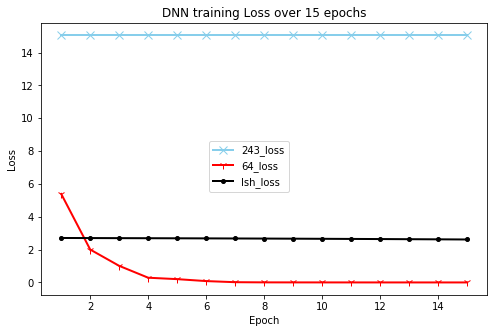

In [81]:
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(epochs, y_loss_243, marker='x', markerfacecolor='blue', markersize=8, color='skyblue', linewidth=2)
ax1.plot(epochs, y_loss_64, marker='1', markerfacecolor='red', markersize=8, color='red', linewidth=2)
ax1.plot(epochs, y_loss_lsh, marker='.', markerfacecolor='black', markersize=8, color='black', linewidth=2)

fig.legend(('243_loss', '64_loss', 'lsh_loss'), loc='center')
plt.title("DNN training loss over 15 epochs")
ax1.set_ylabel('Loss', color='black')
ax1.set_xlabel('Epoch', color='black')

plt.show();

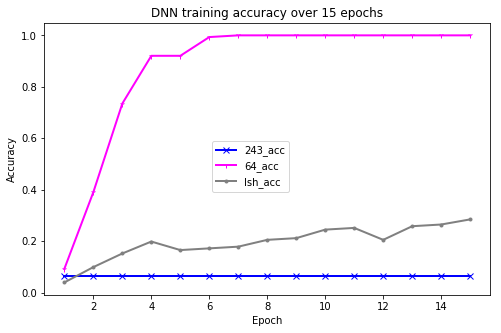

In [82]:
fig, ax2 = plt.subplots(figsize=(8,5))

ax2.plot(epochs, y_acc_243, marker='x', color='blue', linewidth=2)
ax2.plot(epochs, y_acc_64, marker='1', color='magenta', linewidth=2)
ax2.plot(epochs, y_acc_lsh, marker='.', color='grey', linewidth=2)

fig.legend(('243_acc', '64_acc', 'lsh_acc'), loc='center')
plt.title("DNN training accuracy over 15 epochs")
ax2.set_ylabel('Accuracy', color='black')
ax2.set_xlabel('Epoch', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.show();

# 2. Adaptive Dropout and Low-Rank Networks on MNIST data

## Modified fly network
We make an _ad hoc_ modified fly network, allowing for convolution and x-fold dimensionality increase

In [106]:
def orn_to_pn(orn):
    orn_mean = np.mean(orn, axis=1)
    pn = np.array([orn[i]-orn_mean[i] for i in range(len(orn_mean))])
    return pn


def mat_generate(pn_dim, kc_dim, con):
    mat = np.zeros((pn_dim,kc_dim))
    for i in range(kc_dim):
        one_ind = np.random.choice(pn_dim, con, replace=False)
        for j in range(con):
            mat[one_ind[j]][i] = 1
    return mat
    
def pn_to_kc(pn, fold, con, mat): # 40-fold expansion
    sample = np.shape(pn)[0]
    pn_dim = np.shape(pn)[1]
    kc_dim = pn_dim * fold
    
    #print(mat)
    kc = np.dot(pn, mat)
    return kc

def wta(kc, top_percent):
    kc_dim = np.shape(kc)[1]
    final = np.zeros(np.shape(kc))
    k = int(kc_dim * top_percent) # k >= 1 && k < len
#     print (k)
    for i in range(len(kc)):
        sample = kc[i]
        ind = np.argpartition(sample, -k)[-k:][0]
        pivot = sample[ind]
        for j in range(kc_dim):
            final[i][j] = 0 if kc[i][j] < pivot else kc[i][j]
    return final

def fly(input_data, fold, con, top_percent, mat):
    pn = orn_to_pn(input_data)
    kc = pn_to_kc(pn, fold, con, mat)
    r = wta(kc, 0.05)
    return r

### Read MNIST samples
And downsoze to 5 or 10k training inputs

In [102]:
# Read MNIST samples
train, validate, test = mnist_loader.load_data_wrapper()
sizeTrain = 5000 # max 60000
sizeTest = 1000 # max 10000
np_train_data = np.array(train[0][:sizeTrain])
np_train_label = np.array(train[1][:sizeTrain])
np_test_data = np.array(test[0][:sizeTest])
np_test_label = np.array(test[1][:sizeTest])

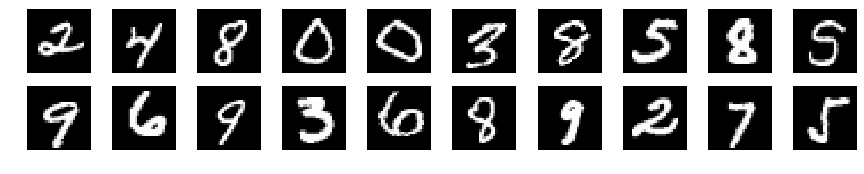

In [103]:
# Display some sample digit images
plt.figure(figsize=[15,4])
n_digits = 20
for n in range(n_digits):
    idx = np.random.randint(10000)
    plt.subplot(3,10,n+1)
    plt.imshow(np.reshape(test[0][idx], [28,28]), cmap='gray'); plt.axis('off');

### KNN wrapper for sklearnknn

In [104]:
# KNN directly
# k takes from startRange to startRange+numOfRange
def sklearnKnn(data, test, startRange, numOfRange=1):
    # effective length for knn training and testing
    input_len = 5000
    test_len = 1000
    kAcc = np.zeros((startRange+numOfRange))
    train_in = np.array(data[0][:input_len])
    label_in = np.array(data[1][:input_len])
    train_test = np.array(test[0][:test_len])
    label_test = np.array(test[1][:test_len])
    print(np.shape(train_in))
    print(np.shape(label_in))
    print(np.shape(train_test))
    print(np.shape(label_test))
    for k in range(startRange, startRange+numOfRange):
        print ('process K: ', k)
        neigh = KNeighborsClassifier(n_neighbors=k, n_jobs=2)
        neigh.fit(train_in, label_in)
        print ('finish fit K: ', k)
        kAcc[k] = neigh.score(train_test,label_test)
    plt.plot(range(1,startRange+numOfRange),kAcc[1:],'o-')
    plt.ylabel('accuracy')
    plt.xlabel('K')
    #plt.yticks(np.arange(0.72, 0.83, 0.01))
    plt.show()    
    return kAcc

### Simple KNN result on MNIST data

(5000, 784)
(5000, 10)
(1000, 784)
(1000, 10)
process K:  1
finish fit K:  1
process K:  2
finish fit K:  2
process K:  3
finish fit K:  3
process K:  4
finish fit K:  4
process K:  5
finish fit K:  5
process K:  6
finish fit K:  6
process K:  7
finish fit K:  7
process K:  8
finish fit K:  8
process K:  9
finish fit K:  9
process K:  10
finish fit K:  10


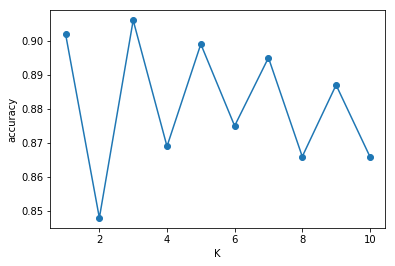

[0.    0.902 0.848 0.906 0.869 0.899 0.875 0.895 0.866 0.887 0.866]


In [105]:
result = sklearnKnn(train, test, 1, 10)
# result = knn(dist)
print (result)

## Run Fly Hashes
Through the modified fly network functions above

In [107]:
# fold 40 con 6

fold = 40
con = 6
top_percent = 0.05

flyTrain_40_6 = np.zeros((np_train_data.shape[0], np_train_data.shape[1] * fold))

print (flyTrain_40_6.shape)
mat_40_6 = mat_generate(np_train_data.shape[1], np_train_data.shape[1]*fold, con)

# fly train data 
flyTrain_40_6 = fly(np_train_data, fold, con, top_percent, mat_40_6)

# fly test data
flyTest_40_6 = fly(np_test_data, fold, con, top_percent, mat_40_6)
print (np.shape(flyTrain_40_6))
print (np.shape(flyTest_40_6))

(5000, 31360)
(5000, 31360)
(1000, 31360)


In [108]:
# fold 40 con 90

fold = 40
con = 90 # similar percentage of 6/50
top_percent = 0.05

flyTrain_40_90 = np.zeros((np_train_data.shape[0], np_train_data.shape[1] * fold))

print (flyTrain_40_90.shape)
mat_40_90 = mat_generate(np_train_data.shape[1], np_train_data.shape[1]*fold, con)

# fly train data 
flyTrain_40_90 = fly(np_train_data, fold, con, top_percent, mat_40_90)

# fly test data
flyTest_40_90 = fly(np_test_data, fold, con, top_percent, mat_40_90)
print (np.shape(flyTrain_40_90))
print (np.shape(flyTest_40_90))

(5000, 31360)
(5000, 31360)
(1000, 31360)


In [110]:
# fold 10 con 90

fold = 10
con = 90 # similar percentage of 6/50
top_percent = 0.05

flyTrain_10_90 = np.zeros((np_train_data.shape[0], np_train_data.shape[1] * fold))

print (flyTrain_10_90.shape)
mat_10_90 = mat_generate(np_train_data.shape[1], np_train_data.shape[1]*fold, con)

# fly train data 
flyTrain_10_90 = fly(np_train_data, fold, con, top_percent, mat_10_90)

# fly test data
flyTest_10_90 = fly(np_test_data, fold, con, top_percent, mat_10_90)
print (np.shape(flyTrain_10_90))
print (np.shape(flyTest_10_90))

(5000, 7840)
(5000, 7840)
(1000, 7840)


### Compare to LSH+KNN

(5000, 31360)
(5000, 10)
(1000, 31360)
(1000, 10)
process K:  1
finish fit K:  1


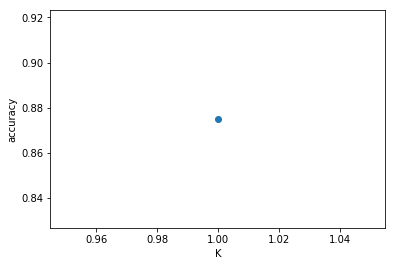

[0.    0.875]


In [112]:
# knn for fly 40 6
result = sklearnKnn([flyTrain_40_6,train[1]], [flyTest_40_6,test[1]], 1)
# result = knn(dist)
print (result)

(5000, 31360)
(5000, 10)
(1000, 31360)
(1000, 10)
process K:  1
finish fit K:  1


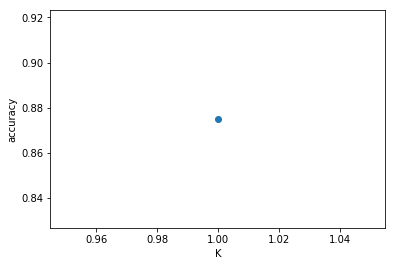

[0.    0.875]


In [115]:
# knn for fly 40 6
result = sklearnKnn([flyTrain_40_6,train[1]], [flyTest_40_6,test[1]], 1)
# result = knn(dist)
print (result)

(5000, 31360)
(5000, 10)
(1000, 31360)
(1000, 10)
process K:  1
finish fit K:  1


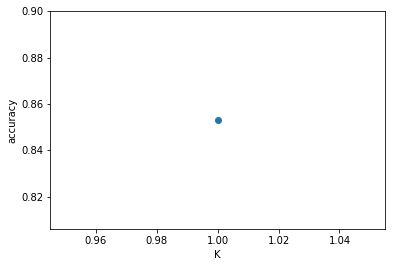

[0.    0.853]


In [116]:
# knn for fly 40 90
result = sklearnKnn([flyTrain_40_90,train[1]], [flyTest_40_90,test[1]], 1)
# result = knn(dist)
print (result)

(5000, 7840)
(5000, 10)
(1000, 7840)
(1000, 10)
process K:  1
finish fit K:  1


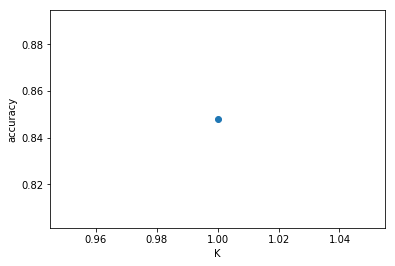

[0.    0.848]


In [117]:
# knn for fly 10 90
result = sklearnKnn([flyTrain_10_90,train[1]], [flyTest_10_90,test[1]], 1)
print (result)

#### Find Specific inputs 2 and 3s...

total processed:  102


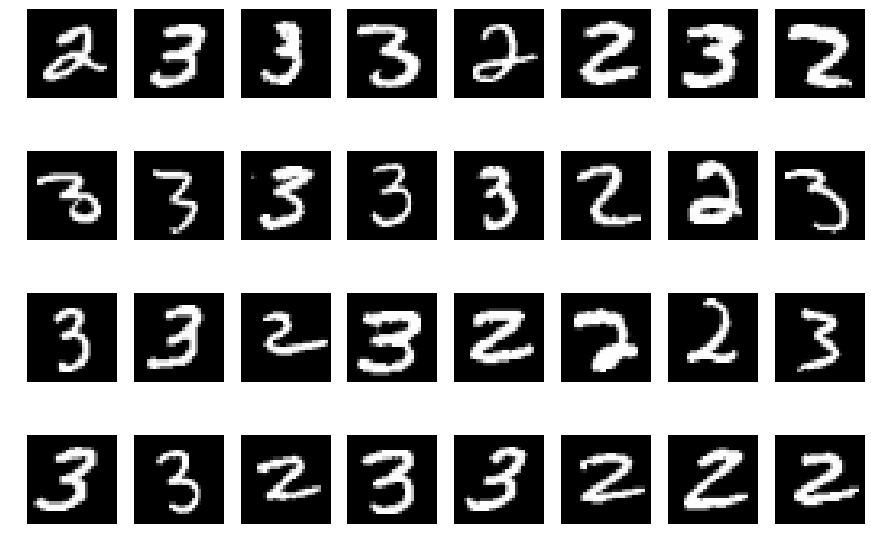

In [118]:
# find 2 and 3 images only
a = findSpecificTrainInput(train, [2,3], maxIndex = 500)
plt.figure(figsize=[15,10])
for n in range(32):
    idx = n
    plt.subplot(4,8,n+1)
    plt.imshow(np.reshape(a[0][idx], [28,28]), cmap='gray'); plt.axis('off');

## 3. DNN on Fly data

### DNN Model on raw data

In [122]:
#model for raw input
model = Sequential()
model.add(Dense(32, input_dim=784, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
time_callback = TimeHistory()
model.fit(np_train_data, np_train_label, epochs=10, callbacks=[time_callback])
times = time_callback.times
print (np.sum(times))

Epoch 1/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.8693 - acc: 0.7768
Epoch 2/10
5000/5000 [==============================] - 0s 94us/step - loss: 0.3732 - acc: 0.9040
Epoch 3/10
5000/5000 [==============================] - 1s 101us/step - loss: 0.2926 - acc: 0.9236
Epoch 4/10
5000/5000 [==============================] - 0s 93us/step - loss: 0.2500 - acc: 0.9324
Epoch 5/10
5000/5000 [==============================] - 0s 85us/step - loss: 0.2216 - acc: 0.9422
Epoch 6/10
5000/5000 [==============================] - 0s 96us/step - loss: 0.2002 - acc: 0.9436
Epoch 7/10
5000/5000 [==============================] - 0s 85us/step - loss: 0.1811 - acc: 0.9508
Epoch 8/10
5000/5000 [==============================] - 0s 82us/step - loss: 0.1656 - acc: 0.9530
Epoch 9/10
5000/5000 [==============================] - 0s 83us/step - loss: 0.1529 - acc: 0.9608
Epoch 10/10
5000/5000 [==============================] - 0s 87us/step - loss: 0.1403 - acc: 0.9618
13.699920177459717

#### And evaluate

In [123]:
model.evaluate(np_test_data, np_test_label)

1000/1000 [==============================] - 0s 383us/step


[0.29518474864959715, 0.902]

### CNN Model on raw data

In [124]:
#CNN for raw input
model = Sequential()
model.add(Reshape((28, 28, 1), input_shape=(784,)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
time_callback = TimeHistory()
model.fit(np_train_data, np_train_label, epochs=10, callbacks=[time_callback])
times = time_callback.times
print (np.sum(times))

Epoch 1/10
5000/5000 [==============================] - 1s 256us/step - loss: 0.5239 - acc: 0.8448
Epoch 2/10
5000/5000 [==============================] - 1s 143us/step - loss: 0.1970 - acc: 0.9418
Epoch 3/10
5000/5000 [==============================] - 1s 145us/step - loss: 0.1163 - acc: 0.9660
Epoch 4/10
5000/5000 [==============================] - 1s 143us/step - loss: 0.0706 - acc: 0.9808
Epoch 5/10
5000/5000 [==============================] - 1s 142us/step - loss: 0.0443 - acc: 0.9878
Epoch 6/10
5000/5000 [==============================] - 1s 144us/step - loss: 0.0282 - acc: 0.9936
Epoch 7/10
5000/5000 [==============================] - 1s 142us/step - loss: 0.0174 - acc: 0.9948
Epoch 8/10
5000/5000 [==============================] - 1s 142us/step - loss: 0.0112 - acc: 0.9974
Epoch 9/10
5000/5000 [==============================] - 1s 142us/step - loss: 0.0057 - acc: 0.9988
Epoch 10/10
5000/5000 [==============================] - 1s 142us/step - loss: 0.0042 - acc: 0.9986
7.7070457

#### And evaluate

In [125]:
model.evaluate(np_test_data, np_test_label)

1000/1000 [==============================] - 0s 145us/step


[0.17400183998793364, 0.959]

## Low-Rank DNNs

### Model for fly hashed with 40-fold expansion and conv=6

In [126]:
#model for fly hashed input 40 6
model = Sequential()
model.add(Dense(32, input_dim=31360, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
time_callback = TimeHistory()
model.fit(flyTrain_40_6, np_train_label, epochs=10, shuffle=True, callbacks=[time_callback])
times = time_callback.times
print (np.sum(times))

Epoch 1/10
5000/5000 [==============================] - 2s 445us/step - loss: 0.4605 - acc: 0.8722
Epoch 2/10
5000/5000 [==============================] - 2s 356us/step - loss: 0.0804 - acc: 0.9742
Epoch 3/10
5000/5000 [==============================] - 2s 340us/step - loss: 0.0270 - acc: 0.9920
Epoch 4/10
5000/5000 [==============================] - 2s 335us/step - loss: 0.0098 - acc: 0.9974
Epoch 5/10
5000/5000 [==============================] - 2s 329us/step - loss: 0.0022 - acc: 0.9996
Epoch 6/10
5000/5000 [==============================] - 2s 330us/step - loss: 0.0022 - acc: 0.9994
Epoch 7/10
5000/5000 [==============================] - 2s 334us/step - loss: 0.0010 - acc: 0.9998
Epoch 8/10
5000/5000 [==============================] - 2s 350us/step - loss: 2.1256e-04 - acc: 0.9998
Epoch 9/10
5000/5000 [==============================] - 2s 342us/step - loss: 4.0109e-06 - acc: 1.0000
Epoch 10/10
5000/5000 [==============================] - 2s 356us/step - loss: 3.1958e-06 - acc: 1.00

#### And evaluate

In [127]:
model.evaluate(flyTest_40_6, np_test_label)

1000/1000 [==============================] - 0s 368us/step


[0.4105046369861811, 0.935]

### Model for fly hashed with 40-fold expansion, conv=6, _and_ additonal hidden layers
That is, add in hidden low-rank layers to (hopefully) simplify weights

In [128]:
# more layer for fly hashed data 40 6
model = Sequential()
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
time_callback = TimeHistory()
model.fit(flyTrain_40_6, np_train_label, epochs=10, shuffle=True, callbacks=[time_callback])
times = time_callback.times
print (np.sum(times))

Epoch 1/10
5000/5000 [==============================] - 2s 461us/step - loss: 0.4569 - acc: 0.8726 0s - loss: 0.4643 - acc: 0.87
Epoch 2/10
5000/5000 [==============================] - 2s 362us/step - loss: 0.0927 - acc: 0.9748
Epoch 3/10
5000/5000 [==============================] - 2s 367us/step - loss: 0.0278 - acc: 0.9910
Epoch 4/10
5000/5000 [==============================] - 2s 376us/step - loss: 0.0136 - acc: 0.9960
Epoch 5/10
5000/5000 [==============================] - 2s 365us/step - loss: 0.0023 - acc: 0.9992
Epoch 6/10
5000/5000 [==============================] - 2s 376us/step - loss: 0.0039 - acc: 0.9982
Epoch 7/10
5000/5000 [==============================] - 2s 364us/step - loss: 5.0353e-04 - acc: 0.9998
Epoch 8/10
5000/5000 [==============================] - 2s 368us/step - loss: 1.9258e-04 - acc: 0.9998
Epoch 9/10
5000/5000 [==============================] - 2s 384us/step - loss: 6.7812e-06 - acc: 1.0000
Epoch 10/10
5000/5000 [==============================] - 2s 385us/s

#### And evaluate

In [129]:
model.evaluate(flyTest_40_6, np_test_label)

1000/1000 [==============================] - 0s 343us/step


[0.5758868483174592, 0.929]

### FInally, Model for fly hashed with 40-fold expansion and conv=90; 10-fold expansion and conv=90

In [130]:
# model for fly hashed data 40 90
model = Sequential()
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(flyTrain_40_90, np_train_label, epochs=10, shuffle=True, callbacks=[time_callback])
times = time_callback.times
print (np.sum(times))

Epoch 1/10
5000/5000 [==============================] - 2s 432us/step - loss: 0.7115 - acc: 0.8380
Epoch 2/10
5000/5000 [==============================] - 2s 334us/step - loss: 0.1577 - acc: 0.9634
Epoch 3/10
5000/5000 [==============================] - 2s 339us/step - loss: 0.0609 - acc: 0.9874
Epoch 4/10
5000/5000 [==============================] - 2s 367us/step - loss: 0.0365 - acc: 0.9934ETA: 1s
Epoch 5/10
5000/5000 [==============================] - 2s 368us/step - loss: 0.0240 - acc: 0.9966
Epoch 6/10
5000/5000 [==============================] - 2s 379us/step - loss: 0.0200 - acc: 0.9986
Epoch 7/10
5000/5000 [==============================] - 2s 382us/step - loss: 0.0173 - acc: 0.9982
Epoch 8/10
5000/5000 [==============================] - 2s 363us/step - loss: 0.0155 - acc: 0.9990
Epoch 9/10
5000/5000 [==============================] - 2s 367us/step - loss: 0.0138 - acc: 0.9990
Epoch 10/10
5000/5000 [==============================] - 2s 361us/step - loss: 0.0134 - acc: 0.9990
18

#### And evaluate

In [131]:
model.evaluate(flyTest_40_90, np_test_label)

1000/1000 [==============================] - 0s 365us/step


[0.6525239945249632, 0.929]

In [132]:
#model for fly hashed input 10 90
model = Sequential()
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(flyTrain_10_90, np_train_label, epochs=10, shuffle=True, callbacks=[time_callback])
times = time_callback.times
print (np.sum(times))

Epoch 1/10
5000/5000 [==============================] - 1s 254us/step - loss: 0.4684 - acc: 0.8620
Epoch 2/10
5000/5000 [==============================] - 1s 151us/step - loss: 0.0670 - acc: 0.9808
Epoch 3/10
5000/5000 [==============================] - 1s 178us/step - loss: 0.0179 - acc: 0.9946
Epoch 4/10
5000/5000 [==============================] - 1s 166us/step - loss: 0.0068 - acc: 0.9990
Epoch 5/10
5000/5000 [==============================] - 1s 172us/step - loss: 0.0035 - acc: 0.9998
Epoch 6/10
5000/5000 [==============================] - ETA: 0s - loss: 0.0037 - acc: 0.999 - 1s 164us/step - loss: 0.0036 - acc: 0.9996
Epoch 7/10
5000/5000 [==============================] - 1s 184us/step - loss: 0.0032 - acc: 0.9998
Epoch 8/10
5000/5000 [==============================] - 1s 184us/step - loss: 0.0032 - acc: 0.9998
Epoch 9/10
5000/5000 [==============================] - 1s 170us/step - loss: 0.0032 - acc: 0.9998
Epoch 10/10
5000/5000 [==============================] - 1s 173us/step 

#### And evaluate

In [ ]:
model.evaluate(flyTest_10_90, np_test_label)

# 3. Adaptive Dropout

### Use the same MNIST train and test data as in Low-Rank, above

In [134]:
print (np_train_data.shape)
print (np_test_data.shape)
print (np_train_label.shape)
print (np_test_label.shape)

(5000, 784)
(1000, 784)
(5000, 10)
(1000, 10)


## Implement the Adaptive Dropout Class

In [135]:
adapt_dropout_rate = 0.6
cur_epoch = 1
total_epochs = 10

# callback class at the end of each epoch to increment cur_epoch
class IncCurEpoch(keras.callbacks.Callback):
    def __init__(self):
        self.counter_list = []
        self.temp = []
        
    def on_train_begin(self, logs={}):
        self.counter_list = []
        self.temp = []

    def on_epoch_end(self, batch, logs={}):
        global cur_epoch
        self.counter_list.append(cur_epoch)
        self.temp.append(max(0, 1-cur_epoch/total_epochs) * adapt_dropout_rate)
        cur_epoch += 1
        
    def show_counter_list(self):
        print (self.counter_list)
        print (self.temp)

class Dropout(Layer):
    ''' 
        Applies Dropout to the input. Dropout consists in randomly setting
        a fraction p of input units to 0 at each update during training time,
        which helps prevent overfitting.

        # Arguments
            p: float between 0 and 1. Fraction of the input units to drop.

        # References
            - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)
    '''
    def __init__(self, p, adaptive=False, **kwargs):
        self.init_p = p
        self.p = p
        self.adaptive = adaptive
        if 0. < self.init_p < 1.:
            self.uses_learning_phase = True
        self.supports_masking = True
        super(Dropout, self).__init__(**kwargs)

    def call(self, x, mask=None):
        self.p = max(0, 1-cur_epoch/total_epochs) * self.init_p if self.adaptive else self.init_p
        if 0. < self.init_p < 1.:
            x = K.in_train_phase(K.dropout(x, level=self.p), x)
        return x

    def get_config(self):
        config = {'p': self.p}
        base_config = super(Dropout, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Create adaptive model for 40-fold expansion and conv=6

In [136]:
#model for adaptive dropout fly hashed input 40 6
adapt_dropout_rate = 0.5
cur_epoch = 1
inc_cur_epoch = IncCurEpoch()
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dropout(adapt_dropout_rate, adaptive=True))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(flyTrain_40_6, np_train_label, epochs=10, shuffle=True, callbacks=[inc_cur_epoch,time_callback])
times = time_callback.times
print (np.sum(times))

Epoch 1/10
5000/5000 [==============================] - 2s 487us/step - loss: 0.9439 - acc: 0.6870
Epoch 2/10
5000/5000 [==============================] - 2s 348us/step - loss: 0.4986 - acc: 0.8316
Epoch 3/10
5000/5000 [==============================] - 2s 369us/step - loss: 0.3683 - acc: 0.8796
Epoch 4/10
5000/5000 [==============================] - 2s 335us/step - loss: 0.3020 - acc: 0.9072
Epoch 5/10
5000/5000 [==============================] - 2s 352us/step - loss: 0.2853 - acc: 0.9132
Epoch 6/10
5000/5000 [==============================] - 2s 348us/step - loss: 0.2425 - acc: 0.9188
Epoch 7/10
5000/5000 [==============================] - 2s 354us/step - loss: 0.2066 - acc: 0.9368
Epoch 8/10
5000/5000 [==============================] - 2s 348us/step - loss: 0.2056 - acc: 0.9380
Epoch 9/10
5000/5000 [==============================] - 2s 344us/step - loss: 0.1930 - acc: 0.9410
Epoch 10/10
5000/5000 [==============================] - 2s 339us/step - loss: 0.1803 - acc: 0.9450
18.124353

#### And evaluate

In [137]:
model.evaluate(flyTest_40_6, np_test_label)

1000/1000 [==============================] - 0s 376us/step


[0.4397753999531269, 0.92]

### Compare to static Dropout model (40-fold and conv=6)

In [138]:
#model for static dropout fly hashed input 40 6
adapt_dropout_rate = 0.5
cur_epoch = 1
inc_cur_epoch = IncCurEpoch()
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dropout(adapt_dropout_rate, adaptive=False))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(flyTrain_40_6, np_train_label, epochs=10, shuffle=True, callbacks=[inc_cur_epoch,time_callback])
times = time_callback.times
print (np.sum(times))

Epoch 1/10
5000/5000 [==============================] - 3s 503us/step - loss: 1.0377 - acc: 0.6558
Epoch 2/10
5000/5000 [==============================] - 2s 362us/step - loss: 0.6422 - acc: 0.7902
Epoch 3/10
5000/5000 [==============================] - 2s 379us/step - loss: 0.4731 - acc: 0.8516
Epoch 4/10
5000/5000 [==============================] - 2s 367us/step - loss: 0.3772 - acc: 0.8778
Epoch 5/10
5000/5000 [==============================] - 2s 374us/step - loss: 0.3185 - acc: 0.8962
Epoch 6/10
5000/5000 [==============================] - 2s 414us/step - loss: 0.2917 - acc: 0.9028 0s - loss: 0.2941 - acc: 0.90
Epoch 7/10
5000/5000 [==============================] - 2s 390us/step - loss: 0.2520 - acc: 0.9126
Epoch 8/10
5000/5000 [==============================] - 2s 338us/step - loss: 0.2347 - acc: 0.9176
Epoch 9/10
5000/5000 [==============================] - 2s 342us/step - loss: 0.2249 - acc: 0.9184
Epoch 10/10
5000/5000 [==============================] - 2s 378us/step - loss: 

#### And evaluate

In [139]:
model.evaluate(flyTest_40_6, np_test_label)

1000/1000 [==============================] - 1s 726us/step


[0.44891335418820383, 0.925]

### As well, compare adaptive dropout on 10-fold and conv=90 to a static dropout (similar to above)

In [140]:
#model for adaptive dropout fly hashed input 10 90
cur_epoch = 1
inc_cur_epoch = IncCurEpoch()
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dropout(adapt_dropout_rate, adaptive=True))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(flyTrain_10_90, np_train_label, epochs=20, shuffle=True, callbacks=[inc_cur_epoch,time_callback])
times = time_callback.times
print (np.sum(times))

Epoch 1/20
5000/5000 [==============================] - 2s 318us/step - loss: 0.9729 - acc: 0.7016
Epoch 2/20
5000/5000 [==============================] - 1s 172us/step - loss: 0.4678 - acc: 0.8632
Epoch 3/20
5000/5000 [==============================] - 1s 151us/step - loss: 0.3133 - acc: 0.9006
Epoch 4/20
5000/5000 [==============================] - 1s 149us/step - loss: 0.2419 - acc: 0.9240
Epoch 5/20
5000/5000 [==============================] - 1s 151us/step - loss: 0.2056 - acc: 0.9372
Epoch 6/20
5000/5000 [==============================] - 1s 154us/step - loss: 0.1839 - acc: 0.9442
Epoch 7/20
5000/5000 [==============================] - 1s 155us/step - loss: 0.1556 - acc: 0.9520
Epoch 8/20
5000/5000 [==============================] - 1s 167us/step - loss: 0.1781 - acc: 0.9488
Epoch 9/20
5000/5000 [==============================] - 1s 183us/step - loss: 0.1319 - acc: 0.9568
Epoch 10/20
5000/5000 [==============================] - 1s 154us/step - loss: 0.1120 - acc: 0.9638
Epoch 11/

In [141]:
inc_cur_epoch.show_counter_list()
print (cur_epoch)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15000000000000002, 0.09999999999999998, 0.04999999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
21


#### And evaluate

In [142]:
model.evaluate(flyTest_10_90, np_test_label)

1000/1000 [==============================] - 0s 225us/step


[0.6492534777148102, 0.922]

In [143]:
dropout_rate = adapt_dropout_rate

#model for static dropout fly hashed input 10 90
cur_epoch = 1
inc_cur_epoch = IncCurEpoch()
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dropout(adapt_dropout_rate, adaptive=False))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(flyTrain_10_90, np_train_label, epochs=20, shuffle=True, callbacks = [inc_cur_epoch])

Epoch 1/20
5000/5000 [==============================] - 2s 308us/step - loss: 1.0641 - acc: 0.6580
Epoch 2/20
5000/5000 [==============================] - 1s 146us/step - loss: 0.5093 - acc: 0.8366
Epoch 3/20
5000/5000 [==============================] - 1s 152us/step - loss: 0.3994 - acc: 0.8800
Epoch 4/20
5000/5000 [==============================] - 1s 148us/step - loss: 0.3149 - acc: 0.9054
Epoch 5/20
5000/5000 [==============================] - 1s 161us/step - loss: 0.2640 - acc: 0.9178
Epoch 6/20
5000/5000 [==============================] - 1s 163us/step - loss: 0.2117 - acc: 0.9318
Epoch 7/20
5000/5000 [==============================] - 1s 158us/step - loss: 0.1896 - acc: 0.9378
Epoch 8/20
5000/5000 [==============================] - 1s 149us/step - loss: 0.1847 - acc: 0.9382
Epoch 9/20
5000/5000 [==============================] - 1s 152us/step - loss: 0.1666 - acc: 0.9462
Epoch 10/20
5000/5000 [==============================] - 1s 154us/step - loss: 0.1483 - acc: 0.9514
Epoch 11/

#### And evaluate (10-fold conv=90, static dropout)

In [144]:
model.evaluate(flyTest_10_90, np_test_label)

1000/1000 [==============================] - 0s 235us/step


[0.5271735529601574, 0.923]